# RGI05 (Greenland Periphery)

F. Maussion, S. Galos & F. Roura-Adseiras

Goal: same as RGI6 except in Northeast with an update from Zürich and Flade Isblink from Bob.

**Note: connectivity level 2 is removed.**

In [2]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, correct_geoms
import os

## Files and storage paths

In [3]:
# Region of interest
reg = 5

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '05_rgi60_GreenlandPeriphery.zip')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
92,260,55008.2,Jiskoot,Jiskoot,2005,East Central Greenland,1995,1995,1995
474,35,633.4,Meyer,Meyer,2008,Northeast Greenland,2001,2001,2001
475,15,527.7,Meyer,Meyer,2008,Northeast Greenland,2001,2001,2001
696,3938,4708.1,"Paul, Rastner, Schaub",Paul,2018,Various (GlobGlacier),2016,2015,2016
729,715,3233.0,"Paul, Rastner",Paul,2021,Greenland,1978,1978,1978
751,20261,130071.1,"Bolch, Howat, LeBris, Moelg, Negrete, Paul, Ra...",Cogley,2014,Randolph Glacier Inventory; Umbrella RC for me...,2001,1994,2010
813,202,10228.3,McNabb,McNabb,2023,NE Greenland,2001,1999,2001


Notes based on individual submission evaluations: 

- 751: This is the RGI
- 729: update for a region in NE
- 813: Bob  update

In [7]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

### Apply selection criteria to create the RGI7 data subset

In [8]:
# We use 'subm_id' = 751 as our main dataset
RGI_ss_751 = shp.loc[shp['subm_id'] == 751].copy()
RGI_ss_751['is_rgi6'] = True

# The subm_id = 729 will be added to subm_id=580 after some actions
RGI_ss_729 = shp.loc[shp['subm_id'] == 729].copy()
RGI_ss_729['is_rgi6'] = False

# The subm_id = 813 will be added to subm_id=580 after some actions
RGI_ss_813 = shp.loc[shp['subm_id'] == 813].copy()
RGI_ss_813['is_rgi6'] = False

In [9]:
RGI_ss_751['conn_lvl'].unique()

array([0., 1., 2.])

In [10]:
(RGI_ss_751['conn_lvl'] == 2).sum()

955

In [12]:
RGI_ss_729['conn_lvl'].unique(), RGI_ss_813['conn_lvl'].unique()

(array([0.]), array([0.]))

This is just a check - should be no problem:

In [13]:
# Overlay GLIMS 751 with RGI in order to get the CL attrs
from utils import open_zip_shapefile
ref_rgi6 = open_zip_shapefile(rgi6_reg_file)
rp = RGI_ss_751.representative_point()
rp = gpd.GeoDataFrame(rp, columns=['geometry'])
rp['orig_index'] = RGI_ss_751.index
isin = gpd.overlay(rp, ref_rgi6, how='intersection').set_index('orig_index')
RGI_ss_751['RGI6_Id'] = isin['RGIId']

In [14]:
# Checks
assert len(isin) == len(RGI_ss_751), len(isin) == len(ref_rgi6)
ref_rgi6['area'] = ref_rgi6.to_crs({'proj':'cea'}).area
assert (isin['RGIId'] == '').sum() == 0
np.testing.assert_allclose(RGI_ss_751['area'], ref_rgi6.set_index('RGIId').loc[RGI_ss_751['RGI6_Id']]['area'].values, rtol=0.001)

In [15]:
# Most important 
connect_rgi = ref_rgi6.set_index('RGIId').loc[RGI_ss_751['RGI6_Id']]['Connect'].values.astype(int)
np.testing.assert_allclose(RGI_ss_751['conn_lvl'], connect_rgi)

In [16]:
# Keep only ids with CL != 2
print(len(RGI_ss_751))
RGI_ss_751 = RGI_ss_751.loc[RGI_ss_751['conn_lvl'] < 2]
print(len(RGI_ss_751))

20261
19306


In [17]:
# Read box containing glaciers with subm_id = 729
rgi_729_box = data_dir + f'/l0_support_data/rgi{reg:02d}_north_outline_sel_box.zip'
box = open_zip_shapefile(rgi_729_box)

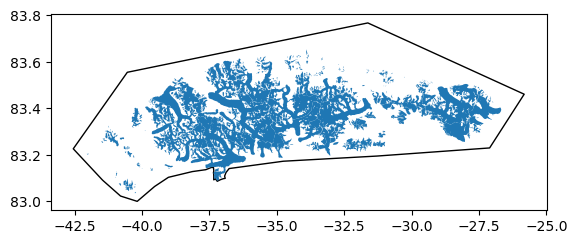

In [18]:
# Plot correct glaciers and shapefile
base = box.plot(color='none', edgecolor='black')
RGI_ss_729.geometry.plot(ax=base, color='C0', markersize=5);

We see that for sumb_id = 729 all glaciers fall inside the box polygon.

Now we remove the glaciers inside and add the RGI_ss_729 to RGI_ss:

In [19]:
# Save glacier centroid in rp:
rp = RGI_ss_751.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = RGI_ss_751.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporary variable
RGI_ss_751_sel = RGI_ss_751.loc[difference['orig_index']]

Same of Flade Isblink:

In [20]:
rgi_813_box = data_dir + f'/l0_support_data/flade_box.zip'
box = open_zip_shapefile(rgi_813_box)

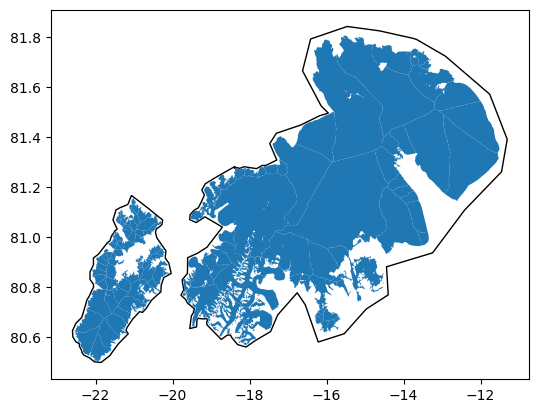

In [21]:
# Plot correct glaciers and shapefile
base = box.plot(color='none', edgecolor='black')
RGI_ss_813.geometry.plot(ax=base, color='C0', markersize=5);

In [22]:
# Save glacier centroid in rp:
rp = RGI_ss_751_sel.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = RGI_ss_751_sel.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporary variable
RGI_ss_751_sel_2 = RGI_ss_751_sel.loc[difference['orig_index']]

In [23]:
# Merge original RGI 751 (without the glaciers in the boxes) and the new inventories
rgi7 = pd.concat([RGI_ss_751_sel_2, RGI_ss_729, RGI_ss_813])

### Some sanity checks 

In [24]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [25]:
rgi7 = correct_geoms(rgi7)

Found 1416 invalid geometries out of 19971. Correcting...
High correction: 791655. Area diff: -30083.29525940772 m2 (-15.8102%) Smaller than 0.1 km2. Ignoring.
High correction: 799196. Area diff: -547.1454707088487 m2 (-0.9685%) Smaller than 0.1 km2. Ignoring.
After correction, 0 geometries are still invalid.
Area changed by -30630.4 m2 (-0.0000%)


In [27]:
rgi7 = size_filter(rgi7)

In [28]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
751,19054,19054
729,715,715
813,200,200


In [29]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    if np.any(np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())):
        print('Orphan rock outcrops detected.')

### Plots 

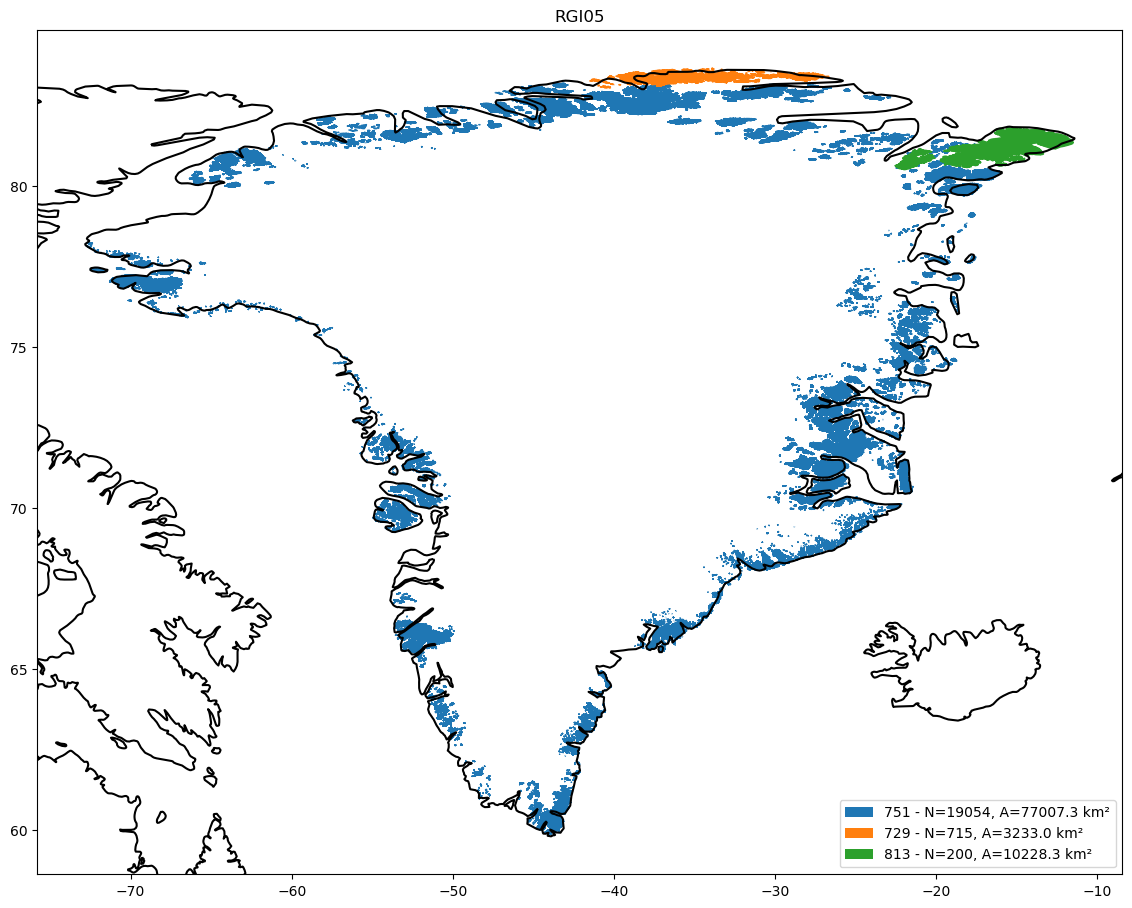

In [30]:
plot_map(rgi7, reg, aspect=2, loc='lower right')

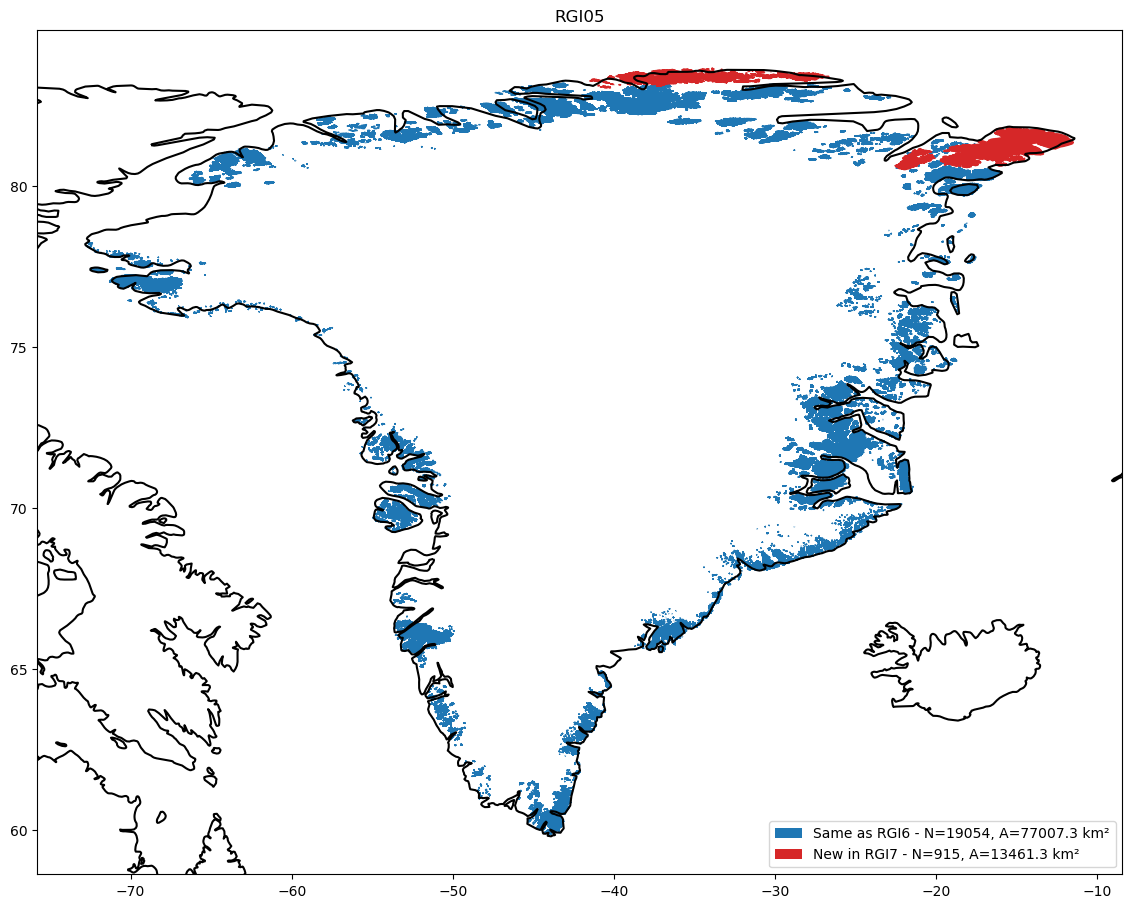

In [31]:
plot_map(rgi7, reg, is_rgi6=True, aspect=2, loc='lower right')

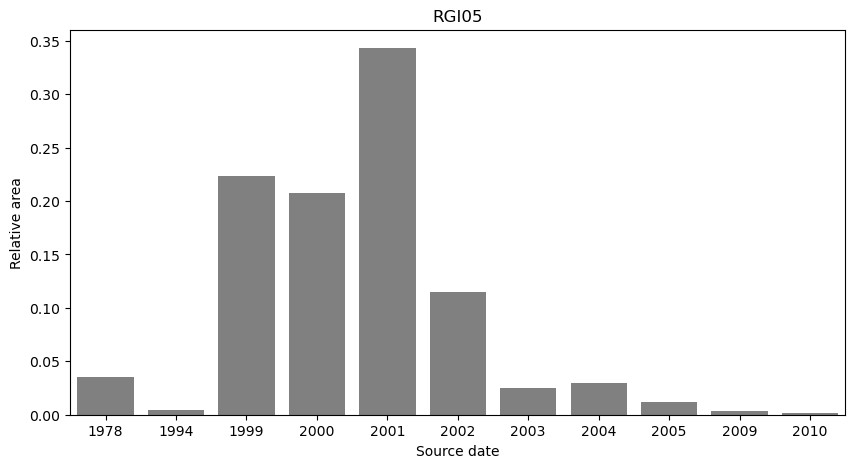

In [32]:
plot_date_hist(rgi7, reg)

### Text for github

In [33]:
fgh = sdf.T
fgh

subm_id,751,729,813
N,19054,715,200
A,77007.3,3233.0,10228.3
analysts,"Bolch, Howat, LeBris, Moelg, Negrete, Paul, Ra...","Paul, Rastner",McNabb
submitters,Cogley,Paul,McNabb
release_date,2014,2021,2023
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,Greenland,NE Greenland
src_date_mode,2001,1978,2001
src_date_min,1994,1978,1999
src_date_max,2010,1978,2001


In [34]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 751                                                                    | 729           | 813          |
|:--------------|:-----------------------------------------------------------------------|:--------------|:-------------|
| N             | 19054                                                                  | 715           | 200          |
| A             | 77007.3                                                                | 3233.0        | 10228.3      |
| analysts      | Bolch, Howat, LeBris, Moelg, Negrete, Paul, Rastner                    | Paul, Rastner | McNabb       |
| submitters    | Cogley                                                                 | Paul          | McNabb       |
| release_date  | 2014                                                                   | 2021          | 2023         |
| geog_area     | Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS | Greenland     | NE Greenland |
| src_date_mode | 2001  

## Write out and tar 

In [35]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI05/
RGI05/RGI05.shp
RGI05/RGI05.dbf
RGI05/RGI05.shx
RGI05/RGI05.cpg
RGI05/RGI05.prj
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI05.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI05'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6 and Philipp) to enable comparison

In [34]:
# load reference data
ref_rgi6 = open_zip_shapefile(rgi6_reg_file)
ref_pr = open_zip_shapefile(data_dir + '/l0_support_data/c3s_gi_rgi05_aero_1978.zip')

In [35]:
# Remove CL2
ref_rgi6 = ref_rgi6.loc[ref_rgi6['Connect'] < 2]

### Number of elements (differences do not depict problems)

In [36]:
print('Number of glaciers in new RGI:', len(rgi7))
print('Number of glaciers in RGI6:', len(ref_rgi6))
print('Difference:', len(rgi7)-len(ref_rgi6))

Number of glaciers in new RGI: 19888
Number of glaciers in RGI6: 19306
Difference: 582


### How many nominal glaciers were there in RGI06?

In [37]:
len(ref_rgi6.loc[ref_rgi6.Status == 2])

0

### Total area

In [38]:
# add an area field to RGI_ss and reference data
ref_rgi6['area'] = ref_rgi6.to_crs({'proj':'cea'}).area
ref_pr['area'] = ref_pr.to_crs({'proj':'cea'}).area

### Northern Greenland (729, Rastner, no problem there):  

In [39]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_729))
print('Number of glaciers in reference data (FP):', len(ref_pr))
print('Difference:', len(RGI_ss_729)-len(ref_pr))

Number of glaciers in RGI7 subset: 715
Number of glaciers in reference data (FP): 715
Difference: 0


In [40]:
# print and compare area values
Area_7 = RGI_ss_729['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_pr['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 3232.9828018818616
Area RGI6 [km²]: 3232.983238523939
Area difference [km²]: -0.0004366420771475532


This is brilliant! No issue there.

### Rest of Greenland (used to be problems, now SOLVED):  

In [41]:
# Save glacier centroid in rp:
rp = ref_rgi6.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = ref_rgi6.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporal variable
ref_rgi6_sel = ref_rgi6.loc[difference['orig_index']]

In [42]:
needs_size_filter(ref_rgi6_sel)

False

In [43]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_751_sel))
print('Number of glaciers in reference data (RGI6):', len(ref_rgi6_sel))
print('Difference:', len(RGI_ss_751_sel)-len(ref_rgi6_sel))

Number of glaciers in RGI7 subset: 19173
Number of glaciers in reference data (RGI6): 19173
Difference: 0


In [44]:
# print and compare area values
Area_7 = RGI_ss_751_sel['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_rgi6_sel['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 87137.80287469726
Area RGI6 [km²]: 87137.80769510278
Area difference [km²]: -0.004820405520149507


In [45]:
# When there was an error:
# Area RGI7 [km²]: 128053.48756764423
# Area RGI6 [km²]: 127491.90330300487
# Area difference [km²]: 561.5842646393576